In [1]:
import configparser
import qiskit as qk
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy

In [2]:
# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x,
                    'y':quantum_circuit.y,
                    'z':quantum_circuit.z,
                    'h':quantum_circuit.h,                    
                    't':quantum_circuit.t,                    
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg

    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]]

In [3]:
# Create the quantum circuit
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

''' Qubit ordering as follows (classical registers will just contain measured values of the corresponding qubits):
q[0]: qubit to be teleported (Alice's first qubit. It was given to her after the application of a secret unitary 
      which she doesn't know)
q[1]: Alice's second qubit
q[2]: Bob's qubit, which will be the destination for the teleportation
'''
secret_unitary = 'hz'

# Apply the secret unitary that we are using to generate the state to teleport. You can change it to any unitary
apply_secret_unitary(secret_unitary, q[0], qc, dagger = 0)
qc.barrier()
# Next, generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
qc.h(q[1])
qc.cx(q[1], q[2])
qc.barrier()
# Next, apply the teleportation protocol. 
qc.cx(q[0], q[1])
qc.h(q[0])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
qc.barrier()

'''
In principle, if the teleportation protocol worked, we have q[2] = secret_unitary|0>
As a result, we should be able to recover q[2] = |0> by applying the reverse of secret_unitary
since for a unitary u, u^dagger u = I.
'''
apply_secret_unitary(secret_unitary, q[2], qc, dagger=1)
qc.measure(q[2], c[2])

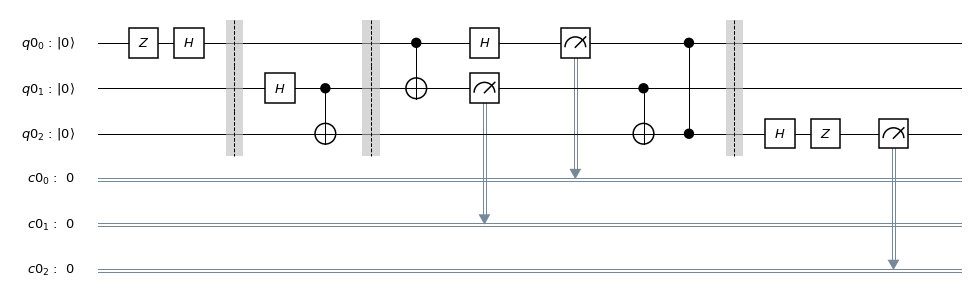

In [4]:
qc.draw(output='mpl')

In [5]:
config = configparser.ConfigParser()
config.read('qiskitrc.config')
IBMQ.save_account(config['IBMQ']['token'], config['IBMQ']['url'])

/home/ankush/.local/lib/python3.6/site-packages/qiskit/providers/ibmq/credentials/configrc.py:130: UserWarning: Credentials already present. Set overwrite=True to overwrite.
  warnings.warn('Credentials already present. '


{'000': 4334, '111': 549, '001': 1358, '110': 1951}


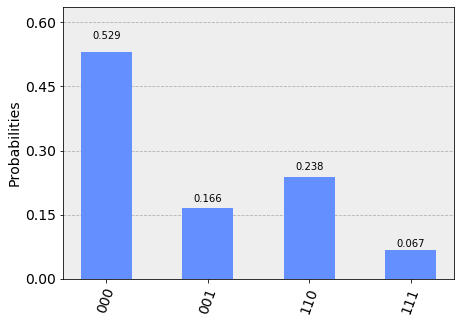

In [6]:
IBMQ.load_accounts()
backend = least_busy(IBMQ.backends(simulator=False))
job_exp = execute(qc, backend=backend, shots=8192)
exp_result = job_exp.result()

exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)